# Import

!pip install numpy
!pip install pandas
!pip install nltk
!pip install tqdm
!pip install gensim
!pip install spacy
!pip install scikit-learn
!pip install matplotlib
!python -m spacy download en_core_web_lg

In [1]:
import numpy as np
import pandas as pd
import nltk
import tqdm
from nltk.corpus import stopwords
import re,string
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import gc
import gensim
import collections
nlp = spacy.load('en_core_web_lg')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 500

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ysiberia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ysiberia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ysiberia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Ysiberia\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# фиксирую рэндом сид чтобы эксперименты были воспроизводимы
np.random.seed(31415)

# Data

df = pd.read_excel('data/vr_ar_classification.xlsx')
df=df.drop(columns=['area','label','keywords_eng','pub_date','link','probability'],axis=1)
df.head()
out_path='data/vr_ar_classification_output.xlsx'  
df=df.dropna(axis='index')
df['sentence'] = df['sentence'].astype("string")
print(df.info())

In [3]:
df = pd.read_excel('data/besprovodnaya_svyaz__0_95_classification.xlsx')
df=df.drop(columns=['area','label','keywords_eng','pub_date','link','probability'],axis=1)
df=df.dropna(axis='index')
df['sentence'] = df['sentence'].astype("string")
print(df.info())
out_path='data/besprovodnaya_svyaz__0_95_classification_output.xlsx'  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28942 entries, 0 to 28947
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  28942 non-null  string
dtypes: string(1)
memory usage: 452.2 KB
None


df = pd.read_excel('data/besprovodnaya_svyaz_classification.xlsx')
df=df.drop(columns=['area','label','keywords_eng','pub_date','link','probability'],axis=1)
df.head()
#7041 unic words

df = pd.read_excel('data/neur_ai_classification.xlsx')
df=df.drop(columns=['area','label','keywords_eng','pub_date','link','probability'],axis=1)
df=df.dropna(axis='index')
df['sentence'] = df['sentence'].astype("string")
print(df.info())
#7041 unic words
out_path='data/neur_ai_classification_out.xlsx'

df = pd.read_excel('data/new_technologies_classification.xlsx')
#df=df.drop(columns=['area1','area2','label','keywords_eng','pub_date','link','probability'],axis=1)
df.head()
#7041 unic words

df = pd.read_excel('data/quants_classification.xlsx')
df=df.drop(columns=['area','label','keywords_eng','pub_date','link','probability'],axis=1)
df.head()
#7041 unic words

df = pd.read_excel('data/rasp_reestr_classification.xlsx')
df=df.drop(columns=['area','label','keywords_eng','pub_date','link','probability'],axis=1)
df.head()
#7041 unic words

df = pd.read_excel('data/robo_classification.xlsx')
df=df.drop(columns=['area','label','keywords_eng','pub_date','link','probability'],axis=1)
df.head()
#7041 unic words

# Preprocessing

In [4]:
gc.collect()
# переводим в нижний регистр, удаляем пунктуацию и цифры, заменяем знаки доллара и евро на слова. 
# удаляются двойные пробелы
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text= re.sub(r'%', ' percent ', text)
    text=re.sub('\$', ' dollar ', text)
    text=re.compile('<.*?>').sub(' ', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', ' ', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text)
    text = re.sub('\s+', ' ', text)  
    return text

In [5]:
# список неинформативных коротки слов которые раньше были аббревиатурой 
# или частным названием. осмысленные не включал bad', 'bag', 'bal', 'box', 'bug'
not_informative_short_words =['aaa', 'acc', 'abi', 'add', 'adt', 'aec', 'afp', 'ana', 'aol', 'apr', 'arc', 'ars', 'ash', 'atm',
                              'aud', 
                              'aug', 'avr', 'awp', 'bay', 'bbm', 'bcc', 'bci', 'ben', 'ble', 'bmi', 'boo', 'cad', 'cap', 'cbs', 
                              'ccd', 'ccp', 'ccs', 'cds', 'cee', 'ces', 'cfo', 'cgi', 'cis', 'cld', 'cns', 'cny', 'cpa', 'cta', 
                              'cto', 'cub', 'cup', 'daf', 'dan', 'daz', 'dci', 'ddr', 'dev', 'dew', 'dfc', 'dgx', 'dip', 'dlc', 
                              'dpb', 'dpi', 'dre', 'eap', 'ebt', 'eco', 'edr', 'eli', 'ems', 'eon', 'eos', 'epa', 'era', 'esa', 
                              'esi', 'etc', 'etf', 'evo', 'faa', 'fab', 'fax', 'fda', 'fed', 'fee', 'fig', 'fis', 'fla', 'fov', 
                              'gag', 'gcg', 'gdp', 'gfk', 'ghz', 'gic', 'glu', 'gos', 'gsm', 'gta', 'gtc', 'gtg', 'gtx', 'hai', 
                              'hbo', 'hed', 'hes', 'hfr', 'hlm', 'hlp', 'hmd', 'hmi', 'hon', 'htv', 'hub', 'hud', 'iab', 'iae', 
                              'ian', 'iap', 'ibd', 'ibm', 'ics', 'idc', 'idg', 'ifa', 'ign', 'igt', 'ihs', 'iii', 'imu', 'inc', 
                              'ind', 'int', 'ion', 'iot', 'ips', 'ise', 'isp', 'iss', 'ive', 'iyl', 'jio', 'jmi', 'jon', 'jun', 
                              'jwn', 'khz', 'kit', 'kwh', 'lab', 'lap', 'las', 'lbe', 'lcd', 'led', 'lgs', 'liu', 'low', 'lpm', 
                              'lrn', 'ltd', 'lte', 'lti', 'lux', 'mah', 'met', 'mhl', 'mid', 'mlg', 'mmo', 'mpg', 'mph', 'mrc', 
                              'mri', 'msc', 'msm', 'msv', 'nab', 'nba', 'nbc', 'nea', 'nfl', 'ngr', 'nov', 'nox', 'npd', 'nsf', 
                              'nsn', 'ntt', 'nuc', 'nzd', 'oak', 'oct', 'odv', 'oem', 'ohm', 'ooh', 'opi', 'opt', 'ore', 'org', 
                              'owc', 'par', 'pbr', 'pci', 'pcs', 'pct', 'phd', 'pic', 'plc', 'ppb', 'ppd', 'ppi', 'ppm', 'pre', 
                              'prn', 'pwc', 'qct', 'qqq', 'qsi', 'qtl', 'rec', 'rig', 'rim', 'rmb', 'roy', 'rpm', 'rtx', 'rue', 
                              'sad', 'sam', 'sas', 'sci', 'sek', 'shp', 'skf', 'sne', 'soc', 'spx', 'sqm', 'srp', 'stx', 'sub', 
                              'swp', 'tap', 'tcl', 'tel', 'tfe', 'thd', 'tim', 'tmr', 'tri', 'tvs', 'uav', 'ubi', 'uhd', 'uks', 
                              'usc', 'utm', 'uva', 'uvb', 'vcs', 'vfr', 'vic', 'von', 'vrd', 'vrs', 'vrx', 'wen', 'wii', 'win', 
                              'wow', 'wwe', 'wwf', 'xie', 'xlk', 'yaw', 'yoy', 'zhu', 'zvi',
                              'aal', 'aap', 'abb', 'abd', 'abp','abu', 'aci', 'acm', 'act', 'ada', 'adi', 'adl', 'adn', 'adr', 
                              'ads', 'aed', 'aeg', 'aep', 'aer', 'afr', 'agg', 'agm', 'agr', 'aha', 'ahs', 'aid', 'aii','ais',
                              'aka', 'ala', 'ali', 'alp', 'als', 'amc', 'ami', 'amn', 'amp', 'amr', 'amt', 'and', 'ant', 'anz',
                              'aok', 'api', 'app', 'aps', 'ari', 'asp', 'asu', 'asx', 'atc', 'ate', 'ati', 'atl', 'atp', 'att',
                              'atw', 'awd', 'aws', 'bac','bbb', 'bbc', 'bbk', 'bcd', 'bce', 'bch', 'bcs', 'bdt', 'beh', 'bet', 
                              'bhp', 'bia', 'bid', 'bif', 'big', 'bin', 'bip', 'bit', 'bli', 'bln', 'blu', 'bmo', 'bms', 'bmw',
                              'bns', 'bpd', 'bpi', 'bpo', 'bps', 'brl', 'bse', 'bss', 'btc', 'bts', 'btu', 'buf', 'bui','bwa', 
                              'byo', 'cae', 'caf', 'cak', 'cbp', 'ccg', 'cch', 'cci', 'ccl', 'cdc', 'cdn', 'cea', 'cem','cfe',
                              'cfs', 'cfu', 'cfx', 'cgo', 'cha', 'chd', 'chf', 'chi', 'chl', 'cho', 'chu', 'cia', 'cin', 'cio',
                              'cit', 'ckd', 'cle', 'clp',  'cmk', 'cmo', 'cmr', 'cms', 'cmt', 'cnb', 'cnc', 'cng', 'cnw', 'com',
                              'con', 'coo','co₂', 'cpc', 'cpe', 'cph', 'cpi', 'cps','cpv', 'cpw', 'crm', 'cry', 'cse', 'csl', 
                              'csm', 'csp', 'csr', 'css', 'cus', 'cut', 'cvc', 'cvg', 'cyn', 'czk', 'dab', 'dal', 'dam', 'das',
                              'dax',  'dbs', 'dcg', 'dcm', 'dda', 'ddh', 'ddt', 'dec', 'del', 'den', 'der', 'des', 'det', 'dft',
                              'dha', 'dhl', 'dhq', 'dig', 'div', 'diy', 'djb', 'dld', 'dlr', 'dmi', 'dmr', 'dna', 'dng', 'doe',
                              'dou', 'dow', 'dsc', 'dsl', 'dso', 'dsp', 'dtc', 'dth', 'dtl', 'dts', 'dtw', 'due', 'dug', 'duo',
                              'dvb',  'dvr', 'dxb', 'eas','ebs', 'eda', 'edm', 'edt', 'eee', 'ees', 'efb', 'egp', 'ehr', 'ehs',
                              'eia', 'eid', 'eir', 'emc', 'emd', 'emi', 'emt', 'emv', 'end', 'eno', 'ent', 'epc', 'epi',  'eqb',
                              'erc', 'ers', 'eso', 'est', 'etb', 'etd', 'ett', 'eur', 'eus', 'evf', 'evm', 'evs', 'ewj', 'ews',
                              'eye', 'fao', 'fat', 'fba', 'fca', 'fcc', 'fcf', 'fci', 'fcs', 'fdi', 'fdn', 'feb', 'fgw','flo',
                              'fly', 'fmc', 'fmi', 'fni', 'fon','fsa', 'fsi', 'fss', 'fst', 'ftc', 'ftr', 'fun', 'fwa', 'fxi', 
                              'gaa', 'gal', 'gan', 'gao', 'gba', 'gbe', 'gby', 'gcf', 'gee', 'gen', 'ges', 'get', 'gfg', 'ggv',
                              'ghg', 'ghs', 'gif', 'gig', 'giv', 'gla', 'gmt', 'gmv', 'gni', 'gnw', 'gpv', 'grm', 'gru', 'gsa',
                              'gsi', 'gsk', 'gst', 'gth', 'gtm', 'gto', 'gun', 'guo', 'gut', 'gva', 'gvt', 'gwe', 'gwh', 'gør',
                              'han', 'har', 'hat', 'hba', 'hbb', 'hcc', 'hcl', 'hdb', 'hdd', 'hdi', 'hdr', 'hdx', 'hem', 'hev', 
                              'hex', 'hey', 'hfc', 'hia', 'hip', 'hit','hkd', 'hkx', 'hlr', 'hns', 'hos', 'hou', 'hpc', 'hpe',
                              'hpj', 'hps', 'hrb', 'hrs', 'htc', 'hts', 'htt', 'hua', 'høy', 'iac', 'ibs', 'ibw', 'ica', 'icn',
                              'icp', 'ict', 'ida', 'idf', 'idh', 'idp', 'idx', 'ied', 'iee', 'ift', 'igr', 'igv', 'iia', 'iin', 'ijj',
                              'ill', 'imf', 'img', 'imo', 'ims', 'ina', 'ing', 'ink', 'inn', 'inr', 'ins', 'ioc', 'ioe', 'ios', 'ipc',
                              'ipd', 'ipo', 'ipr', 'ipv', 'ipx', 'iri', 'irs', 'isi', 'ism', 'itc', 'itm', 'itu', 'itv', 'iuc', 'iwd',
                              'iwf', 'iwr', 'iyt', 'izy', 'jam', 'jan', 'jet', 'jfk', 'jgp', 'jim', 'job', 'jpr', 'jpy', 'jqh', 'jsc',
                              'jui', 'jul', 'kan', 'kfc', 'kgi', 'kgs', 'kid', 'kik', 'kim', 'kkr', 'kla', 'klm', 'kmi', 'kms', 'km²',
                              'koa', 'kph', 'kpn', 'krw', 'kse', 'kts', 'kun', 'kuo', 'kva', 'kvh', 'kwd', 'laa', 'lag', 'lam', 'lan',
                              'lat', 'law', 'lay', 'lbs', 'lcc', 'lce', 'lco', 'lda', 'ldc', 'lee', 'les', 'let', 'lex', 'lgb', 'lie',
                              'lis', 'lla', 'llc', 'lmc', 'lmr', 'lng', 'log', 'loi', 'lok', 'los', 'lot', 'lpg', 'lps', 'lrs', 'lse', 
                              'lsi', 'lsp', 'lsr', 'ltm', 'lui', 'luk', 'lum', 'luo', 'lyf', 'lzo', 'lzt', 'mab',  'mag', 'man',
                              'map', 'mar', 'mat', 'mau','mbb', 'mbs', 'mbu', 'mca', 'mcd', 'mcm', 'mco', 'mdd', 'mdg', 'mdm', 'mdr', 'mea',
                              'med', 'mee', 'mem',  'meq', 'mfi', 'mhi', 'mhs', 'mhz', 'mic', 'mik', 'mil', 'mim',  'mio', 'mir', 'mis',
                              'mit', 'mix', 'mjn', 'mln', 'mms', 'mmt', 'mnf', 'mno', 'mnp', 'mod', 'mog', 'mom', 'mos', 'mou', 'moz',    
                              'mpa', 'mpc', 'mpd', 'mps', 'mrm', 'mro', 'mrp', 'msa', 'msi', 'msn', 'mss', 'mst', 'mtg', 'mtl', 'mtn', 'mts',
                              'mvp', 'mwc', 'mwh', 'máv', 'nas', 'nbn', 'ncr', 'nec', 'net', 'new', 'nfc', 'nff', 'nfv', 'ngh', 'nhk', 'nhn',
                              'nhs', 'nis', 'nok', 'non', 'npt', 'nre', 'nrf', 'nrg', 'nse', 'nsl', 'nsr', 'nsw', 'ntc', 'ntd', 'ntf', 
                              'ntp', 'ntv', 'nwe', 'nws', 'nxp', 'nxt', 'nyg', 'nyj', 'obd', 'obr', 'obs', 'ocf', 'och', 'ocs', 'odd',
                              'odm', 'oee', 'oes', 'ohb', 'oie', 'oil', 'old', 'one', 'ono', 'ons', 'ont', 'orc', 'oro', 'orr', 'osa',
                              'osk', 'ota', 'otc', 'ott', 'owe', 'oza', 'pac', 'pad', 'pan','pbs', 'pbx', 'pcb', 'pch', 'pcl', 'pcp',
                              'pds', 'pdv', 'peg', 'per', 'pet', 'pew', 'pgh', 'phe', 'phl', 'pie', 'pig', 'pin', 'pit', 'pkr', 'pla',
                              'pld', 'plm', 'pls', 'ply', 'pme', 'pnb', 'pod', 'pop', 'pos', 'pot', 'ppg', 'ppp', 'pps', 'ppv', 'prc',
                              'pro', 'prp', 'psg', 'psi', 'psy', 'pta', 'ptp', 'pts', 'pub', 'put', 'pvc', 'pyg', 'qad', 'qar',
                              'qcc', 'qfy', 'qhd', 'qnx', 'qoq', 'qvc', 'rac', 'raj', 'ram', 'ran', 'raw', 'ray', 'rba', 'rbc',
                              'rbi', 'rca', 'rcr', 'rcs', 'rda', 'rdd', 'red', 'ree', 'ren', 'rev', 'rex', 'rey', 'rgb', 'rgu', 
                              'rhi', 'rid', 'ril', 'rio', 'rkg', 'rmg', 'rmi', 'rmr', 'roa', 'roc', 'rod', 'roe', 'rog', 'roi',
                              'rom', 'ron', 'rov','rrb', 'rrh', 'rsa', 'rse', 'rsi', 'rtk', 'rub', 'run', 'rwc', 'saf', 'san',
                              'sao', 'sap', 'sar', 'sat','sba', 'sbc', 'sbi', 'sbo', 'sce', 'scs', 'sdg', 'sdn',
                              'sea', 'sec', 'see', 'sel', 'sen', 'sep', 'ses', 'set', 'sex', 'sfr', 'sgt', 'sgx', 'shy', 
                              'sia', 'sim', 'sis', 'sit', 'siy', 'ski', 'skm', 'skt', 'sky', 'slp', 'smb', 'sme', 'smg',
                              'smh', 'smk', 'smp', 'sms', 'smt', 'sns', 'soi', 'sol', 'som', 'son', 'sot', 'soy', 'spg',
                              'sph', 'spi', 'spy', 'sri', 'ssa', 'ssd', 'sse', 'ssl', 'ssm', 'std', 'stl', 'stp', 'sts',
                              'stv', 'suc', 'sud', 'sui', 'sum', 'sun', 'sur', 'suv', 'svp', 'svw', 'tab', 'tac', 'tad',
                              'tag', 'tal', 'tam', 'tan', 'tas',  'tbr', 'tbs', 'tcf', 'tcm', 'tco', 'tcs', 'tdd',
                              'tdi', 'tdk', 'tec', 'tek',  'ter', 'tex', 'tfa', 'tft', 'the', 'thz', 'tie', 'til', 
                              'tio', 'tip', 'tis', 'tls', 'tms', 'tom', 'ton', 'tpg', 'tpv', 'tpy', 'tre', 'try', 
                              'tsa', 'tse', 'tsr', 'tuc', 'tvb', 'tvc', 'twc', 'twh', 'two', 'txn', 'uae', 'uah', 
                              'ual', 'ubm', 'ubs', 'ucs', 'ufs', 'uhf', 'uhs', 'ulm', 'umc', 'und', 'une', 'upc', 
                              'upi', 'upm', 'ups', 'uqc', 'ure', 'usa', 'usb', 'usd', 'use', 'usf', 'uss', 'usv', 
                              'val', 'van', 'var', 'vas', 'vat', 'vdc', 'vdd', 'ver', 'vfc', 'vha', 'vhf', 'via',
                              'vil', 'vis', 'vnf', 'vni', 'voc', 'vod', 'vpn', 'vrf', 'vtr', 'vzw', 'wal', 'wan',
                              'wap', 'war', 'wav', 'wba', 'web', 'wed', 'wes', 'wet', 'wls', 'wos', 'wpc'
                              , 'wsj', 'wsn', 'wtg', 'www', 'xad', 'xfi', 'xia', 'xin', 'xlv', 'xmi', 'xps', 'xrp',
                              'xue', 'xzz', 'yds', 'yea', 'yen', 'yep','yfm', 'yin', 'ysa', 'ytd', 'yum', 'yun', 'zal',
                              'zee', 'zem', 'zte', 'zto',
                             'aao','abt', 'aca', 'acd', 'ach', 'ack', 'acl', 'acn', 'aco', 'acr', 'acs', 'acv', 'adb', 'adj', 'ado', 
                              'adp','aes', 'aet', 'afl', 'agc', 'agh', 'agi', 'agn','ags', 'agv', 'ahn', 'ahu', 'aig', 'alm', 'alt', 'ama',
                              'ame', 'aml', 'ams', 'amv', 'amy', 'anc','ann', 'aoc', 'aog', 'aon', 'aov', 'apa', 'apd', 'apl', 'apm', 'aqr',
                              'arr','asa', 'asc', 'asd', 'asm', 'asr', 'ata', 'atd', 'ato', 'auf', 'aum','avx', 'awe', 'axa', 'ayx', 'baa',
                              'bam', 'ban', 'bao', 'bar', 'bax', 'bba', 'bbl', 'bca', 'bcf', 'bcm', 'bct', 'bda', 'bdc',
                              'bdo', 'bds', 'bec','bep', 'bgc', 'bgf', 'bgr', 'bhi', 'bim', 'bio', 'bis', 'biu', 'biz', 'bjh', 'bjp',
                              'bjs', 'bkc', 'bkw', 'bls', 'bmc', 'bnp', 'bob', 'boe', 'bol','bpl', 'bpm', 'bpt', 'bra', 'bsa', 'bsi', 'bsv',
                              'bsx', 'bti', 'btl', 'bto', 'btw', 'bud', 'buz', 'bwc', 'cab', 'cac', 'cba', 'cbd', 'cbi', 'cbm', 'cca', 'ccb', 
                              'ccc', 'ccm', 'ccr', 'cdg', 'cdi', 'cdk', 'cdo', 'cdw', 'cdx', 'ceb', 'cec', 'cef', 'cel', 'cep', 'cet', 'cgm',
                              'cgn', 'che', 'cic', 'cke', 'cli', 'cma', 'cme', 'cmf', 'cmi', 'cml', 'cmu', 'cnk', 'cnn', 'cnt', 'cod', 'col',
                              'cor', 'cos','cpg', 'cpm', 'cpo', 'cpp', 'cpr', 'cpt', 'cpu', 'crc', 'cro', 'crv', 'csa', 'csd', 'csf', 'csi',
                              'cso', 'ctd', 'cti', 'ctr', 'cue', 'cuh', 'cvd', 'cvs', 'cwc', 'cxa', 'cxu', 'cys', 'dag', 'dai', 'dao', 'dau',
                              'dbr', 'dcc', 'dco', 'dcp', 'dds', 'dee', 'dei', 'dem', 'dfj', 'dfm', 'dhe', 'dia', 'dif', 'dik', 'dim', 'dkk', 
                              'dkr', 'dlp', 'dls', 'dmc', 'dme', 'dmf', 'dmg', 'dms', 'dnb', 'dnf', 'dno', 'doa', 'doc', 'dod', 'doi', 'doj',
                              'dos', 'dpm', 'dpu', 'drg', 'dss', 'dte', 'dtm', 'dto', 'dtt', 'dun', 'dup', 'dut','dvm', 'dvt', 'dxl', 'dye',
                              'eab', 'eam','ecj', 'ecm', 'ecs', 'edf', 'edp', 'eds', 'edu', 'eeg', 'eff', 'efm', 'egg', 'egm', 'ein', 'eiu',
                              'ekg', 'eld', 'elf', 'ema', 'emr', 'eps', 'erm', 'erp', 'erx', 'esd', 'esn', 'esp', 'eth', 'etl', 'eva', 'exa',
                              'ext', 'eys', 'faf','faq', 'far', 'fay', 'fbi', 'fbr', 'fdp', 'fep', 'fet', 'fft', 'fia', 'fin', 'fkf', 'fld',
                              'flg', 'flu', 'fos', 'fou','fpc', 'fpl', 'fps', 'frr', 'frs', 'fse', 'fsr', 'fte', 'ftk', 'ft³', 'fup', 'fyp',
                              'gac','gbi', 'gbp', 'gbs', 'gca', 'gcc', 'gel','ggr', 'ghk', 'gii', 'gle', 'glj', 'gma', 'gms', 'goa','gox', 'gpa',
                              'grc', 'grp', 'gsr', 'gsu', 'gsv', 'guy', 'gvc', 'gwp','hal', 'hbl', 'hbs', 'hci', 'hcm', 'hcq', 'hcs', 'hdl', 'hdp',
                              'hfn', 'hfo', 'hfs', 'hft', 'hhs', 'hie', 'hiv', 'hla', 'hmh', 'hmq', 'hmx', 'hny', 'hoc', 'hot', 'hrc', 'hrd', 'hsn',
                              'htf', 'htm', 'hue', 'hut', 'hvc', 'hya', 'hzb', 'hzi', 'ias', 'ibc', 'ibn', 'ibo', 'icc', 'icd','icf', 'ico', 'icu',
                              'icy', 'idm', 'ids', 'idw', 'ieg', 'ieo', 'ifr', 'ifs', 'ifx', 'igd', 'igm', 'ihc', 'ihl', 'iis', 'ijb', 'ile', 'ime',
                              'ini', 'inv', 'iod', 'iou', 'ipa', 'ipf', 'ipu', 'iqe', 'iqf', 'irc', 'ird', 'irr', 'isc', 'isg', 'ish', 'iso', 'ist',
                              'ito', 'iva', 'ivc', 'ivf', 'ivp', 'ivr', 'ivv', 'ivy', 'iwg', 'iwv', 'ixc', 'iyk', 'iyw', 'jaw', 'jda', 'jek', 'jft',
                              'jha', 'jhu', 'jit', 'jll', 'joe', 'jog', 'joy', 'jpl', 'kai', 'kar', 'kbr', 'ken','kia', 'koc', 'koh', 'kpa', 'kyc',
                              'lal', 'lau', 'lbp', 'lcs', 'ldl', 'len', 'leo', 'lev', 'lfw', 'lgp', 'lib', 'lip', 'lit', 'liv', 'liz', 'llp', 'lns',
                              'lol', 'lpd', 'lpo', 'lpt', 'ltl', 'ltv', 'luc', 'luz', 'léo','mba', 'mcg', 'mch', 'mcp', 'mcu', 'mcx', 'mdt', 'meg',
                              'mes', 'mfp', 'mgi', 'mgm', 'mig', 'min', 'mlb', 'mld', 'mmc', 'mmp', 'mol', 'moo', 'mov', 'moy', 'mpl','msh',
                              'mso', 'msp', 'msw', 'mtf', 'mtr', 'mtu', 'mtv', 'mud', 'mug', 'mum', 'mwe', 'mws', 'myo', 'myq', 'myr', 'nac',
                              'nam', 'nap', 'nav', 'nbj', 'nbv', 'ncm', 'ncs', 'ndp', 'ndr', 'ndt', 'nei', 'neo', 'neu', 'nev', 'nex', 'nfx',
                              'nga', 'ngc', 'ngi', 'ngo', 'ngp', 'ngs', 'nia', 'nic', 'nih', 'nil', 'nir', 'njm', 'nlp', 'nlu', 'nme', 'nmp',
                              'nmr', 'nmt', 'npa', 'npg', 'npr', 'nps', 'npu', 'npv', 'nra', 'nrm', 'nsa', 'nti', 'nut', 'nxj', 'nyc', 'oab',
                              'obn', 'oca', 'oda', 'ofr', 'oht', 'oig', 'oin', 'ola', 'ole', 'omb', 'opm', 'ops', 'osc', 'osi', 'oto','pag',
                              'pak', 'pal', 'pap', 'pas', 'pat', 'pau', 'pav','pcd', 'pce', 'pcu', 'pdc', 'pdf', 'pdm', 'pec', 'pep', 'pfd',
                              'pfe', 'pfi', 'pga', 'pgi', 'phi', 'php', 'phs', 'pii', 'pim', 'piv', 'pjc', 'pln', 'plp', 'pmi', 'pmp', 'pnc',
                              'pnr', 'poo', 'pou', 'ppa', 'ppl', 'ppo', 'prb', 'prm', 'prt', 'psa', 'psp', 'psr', 'pti', 'pty', 'pud', 'pus',
                              'pvd', 'pvo', 'pvs', 'pvt', 'qia', 'qrr', 'qsr', 'qts', 'que', 'rad', 'rao', 'ras','rcm', 'rct', 'ref', 'rei',
                              'rel', 'rem', 'rep', 'rfp', 'rgc', 'rhb', 'ria', 'ris', 'riv', 'rix', 'riz', 'rna', 'rnn', 'rnr', 'rop', 'row',
                              'rpa', 'rpc', 'rpx', 'rtb', 'rte', 'rti', 'rtl', 'rtp', 'ruh', 'rvx', 'rws', 'rxn','sbb', 'sbs', 'scm', 'scp', 
                              'sdi', 'sdk', 'sdl', 'sdm', 'seo', 'seu', 'sfc', 'sfi', 'sfm', 'sfn', 'sga', 'sha', 'shu', 'sic', 'sig', 'sip',
                              'six', 'ska', 'sku', 'sla', 'slb', 'sls', 'smx', 'snf', 'snr', 'soa', 'sob', 'sou', 'sow', 'sox', 'spf', 'spr',
                              'sps', 'sqe', 'sql', 'sqs', 'src', 'srm', 'sro', 'sst', 'stm', 'sto', 'sue', 'sul', 'svb', 'sve', 'svg', 'sya',
                              'syn', 'sys', 'tao', 'tav', 'tax', 'tay', 'tba', 'tbi', 'tca', 'tcp', 'tct', 'tcv', 'tdp', 'tea', 'ted', 'tem',
                              'teo', 'teu', 'tez', 'tfm', 'tgf', 'tha', 'thb', 'the', 'tif', 'tin', 'tka', 'tko', 'tma', 'tmp', 'tmt', 'tmv',
                              'tmw', 'tns', 'tnt', 'tnw', 'toc', 'toe', 'top', 'tor', 'tow', 'toy', 'tpd', 'tpm', 'tpu', 'trp', 'tru', 'tsi', 
                              'tsv', 'tsx', 'tth', 'tty', 'tvh', 'tvm', 'tvt', 'uas', 'ucc', 'ucl', 'udx', 'ugc', 'ugo', 'uhr', 'uia', 'ulg', 
                              'ull', 'umn', 'uns', 'url', 'uth', 'uto', 'uup', 'vbs', 'vca', 'vda', 'vde', 'vdw', 'vea', 'vec', 'vgb', 'vgg', 
                              'vie', 'vig', 'vii', 'vin', 'viv', 'viz', 'vku', 'vms', 'vos', 'vpa', 'vri', 'vrt', 'vte', 'way', 'wbt', 'wcs', 
                              'wee', 'wef', 'weo', 'wer', 'wfc', 'wfe', 'wfm', 'wfo', 'wit', 'wmo', 'wmt', 'wmw', 'wns', 'wpd', 'wpi', 'wpl', 
                              'wpp', 'wsi', 'wta', 'wti', 'wwt', 'xes', 'xgs', 'xlb', 'xly','xor', 'xpo', 'xrf', 'yap', 'yeo','yrd', 'yue', 'yug',
                              'yuk', 'zaf', 'zar', 'zen', 'zev', 'zip', 'zmr', 'zoo', 'zva', 'çok']


['dj','ar','xr','hz','au','mb','va','co','rs','xs','go','rr','db','ai','tb','os','mp','vs','vp','gb','rf','pm','ml','xp','px','ea','mm','kg','km','mi','hd','ds','ky','tv','ks','fb','hp','nm','ad','µm','sq','uk','bn','kw','cu','sv','th','st','la','sh','lg','ft','ii','ic','ct','vc','mn','xx','bi','id','cb','ap','du','qq','en','sg','ms','bb','pf','ag','li','ka','fy','mr','mc','gm','im','ts','wi','fi','ac','br','nr','av','cd','gp','fm','dr','ha','su','de','rd','xa','eu','sf','mw','oz','lb','ef','hs','wc','cm','ex','gt','gs','rg','bg','mt','je','ip','ed','ey','dc','lu','wu','ev']

In [6]:
# удаление английских частиц и предлогов.
all_stopwords = stopwords.words('english')
def delete_stop_words(string):
    text_tokens = word_tokenize(string)
    tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
    filtered_sentence = (" ").join(tokens_without_sw)
    return filtered_sentence

In [7]:
df['Clean_sentence']=df['sentence'].apply(lambda x: preprocess(x))
df['Clean_sentence']=df.Clean_sentence.apply(delete_stop_words)
#удаляем короткие слова в 2 символы
df['Clean_sentence']=df['Clean_sentence'].apply(lambda x:' '.join( [w for w in x.split() if len(w)>2]))
#удаляем неинформативные слова из списка выше
df['Clean_sentence']=df['Clean_sentence'].apply(lambda x:' '.join( [w for w in x.split() if w not in not_informative_short_words]))
df.head()

,sentence,Clean_sentence
0,Chairman Eric Xu said Huawei’s sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) — up roughly 18 percent from the previous year.,chairman eric said huawei sales revenue likely reach billion yuan dollar billion roughly percent previous year
1,The AI and cognitive market in the UAE is set to grow between 25% and 30% year over year in the next two to three years.,cognitive market grow percent percent year year next three years
2,"Just looking at autonomous vehicles, for example, a latency of 1 millisecond means that data can be shared between cars travelling at 70 miles per hour in 31 millimeters.",looking autonomous vehicles example latency millisecond means data shared cars travelling miles hour millimeters
3,Chairman Eric Xu said Huawei's sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) -- up roughly 18 percent from the previous year.,chairman eric said huawei sales revenue likely reach billion yuan dollar billion roughly percent previous year
4,"And in fiscal 2020, it expects this number to grow 7.8% on a year-over-year basis.",fiscal expects number grow percent year year basis


In [8]:
  #  'communitiesnjfr', 'proceedingfacebook', 'communitybrands', 'marketaccording', 'researchinchina', 'contributionstensorflow', 'representatives', 'undernourishment', 'nanotechnologies', 'underhandedness', 'misidentification', 'shareblackberry', 'authentications', 'leveragedinitial', 'mobilethroughout', 'disproportionately', 'balasubramanian', 'implementations', 'biometricupdate', 'bioluminescence', 'retrotransposon', 'diversification', 'infrastructures', 'vulnerabilities', 'aroundveritasium', 'representational', 'konstantopoulos', 'ventriloquizing', 'unsettlingwherever', 'electrochemical', 'potentiostatically', 'electrospinning', 'differentiation', 'controlparticularly', 'photoprotection', 'radiopharmaceuticals', 'complyadvantage', 'cathodoluminescence', 'supercapacitors', 'nanoparticulate', 'advertisementadjusted', 'phacoemulsification', 'getelementsbytagname', 'popularapproximately', 'blepharoconjunctivitis', 'hyperpigmentation', 'pharmaceuticals', 'coadministration', 'betadataquantadatas', 'unsaponifiables', 'cyclohexylgriselimycin', 'microdermabrasion', 'recommendations', 'electrocatalyst', 'characteristics', 'worldwideenough', 'hexafluorophosphate', 'australopithecus', 'pathophysiology', 'reportsnreports', 'majorcytogenetic', 'cabozantinibarm', 'discontinuations', 'proteobacterium', 'crystallisation', 'environmentally', 'vascularization', 'supplementation', 'membranefiltered', 'ultrafiltration', 'exopolysaccharide', 'multituberculate', 'commercialization', 'palaeoanthropology', 'polyhexylthiophene', 'healthcarestudies', 'realistaccording', 'communitiesless', 'transparencymarketresearch', 'bioinformatician', 'representationword', 'geturlinsidetweet', 'tidytweetistanbul', 'geturlinsideretweet', 'advertisementbut', 'deploymentwhich', 'hospitalizations', 'extraordinarily', 'responsibilities', 'advertisementneither', 'translationalthough', 'advertisementover', 'confidentiality', 'interestflittos', 'advertisementrevenues', 'advertisementour', 'advertisementspam', 'enterprisesmarch', 'taikatranslations', 'highlightscorporatebaidu', 'advertisementinitial', 'advertisementaccording', 'advertisementvaluation', 'advertisementmeanwhile', 'advertisementlanguage', 'advertisementaround', 'translationrozetta', 'thrivedlifvergren', 'technologieshttps', 'kilgraycontactsandor', 'preprocessingthe', 'advertisementthis', 'advertisementinitially', 'advertisementfounded', 'partnersportola', 'advertisementsurveyed', 'discountfurthermore', 'employmentwhich', 'counterintuitive', 'underprivileged', 'advertisementhow', 'transformationindia', 'localgovernment', 'acquisitionsthe', 'everyoneaccording', 'journeydineouts', 'complementarity', 'transformational', 'franciscofacebook', 'implementationcreated', 'lendingcrowdthe', 'indiaautomotive', 'pricewaterhouse', 'personalisation', 'telecommunication', 'unapologetically', 'relationshipsmobile', 'popularityfacebook', 'nonprofitssourcechalk', 'procrastination', 'worldwidesource', 'internationally', 'alliedmarketresearch', 'environmentspeople', 'conclusionaccording', 'messengerfacebook', 'humansaccording', 'cryptocurrencies', 'developmentsecretive', 'humantelligence', 'interconnections', 'landscapeaccording', 'magazineaccording', 'videosaccording', 'businessinsider', 'fiercehealthcare', 'marketingmarketing', 'intelligenceallscripts', 'characterization', 'borsadelcredito', 'healthcareitnews', 'interestmaximize', 'educationvirtual', 'disintermediation', 'bankingaccording', 'returnersproving', 'databasefacebook', 'synchronisation', 'significantmobile', 'postcodeschinapyramid', 'penaltiesfacebook', 'kingdomratesetter', 'deliverabilityroughly', 'entrepreneurial', 'accountstwitter', 'americanexpress', 'competitiveness', 'businessaccording', 'advertisementgermanys', 'underrepresented', 'servicesinfrastructure', 'environmentshybrid', 'businessinsiders', 'edigitalresearch', 'zenithoptimedia', 'internationalsome', 'drivenprimarily', 'operationsintuit', 'fundingaustralian', 'personalizationprevious', 'millionwhatsapp', 'matchupsbroadcast', 'advertisementadvertisementnow', 'marketingaccording', 'advertisementin', 'changesprevious', 'milestonesfiretvamazon', 'purchaseswhilst', 'growthliulishuo', 'assistantsnuance', 'electrification', 'measurementsabout', 'marketstudyreport', 'reclassification', 'communicationmuch', 'transcriptionists', 'accomplishments', 'dissatisfaction', 'bundesnetzagentur', 'videoconferencing', 'smartphoneswith', 'clevelandclinic', 'biopharmaceutical', 'storyconnecticut', 'followsmeanwhile', 'unbankedwithout', 'cadburycraveyard', 'fivethirtyeight', 'possibilitiesbaidu', 'transparencyaccentures', 'advanceaccording', 'intelligencethe', 'entrepreneurship', 'optimizationsmobile', 'traditionalists', 'automationmeaning', 'revenuemediatek', 'interoperability', 'functionalities', 'infrastructuresoperators', 'informationphilips', 'caregiversbetter', 'discoverability', 'cryptocurrencyat', 'companiesamerican', 'advertisementroku', 'cherokeeengines', 'transmissionsall', 'intelligencecigna', 'powerwallswedish', 'intelligencehealth', 'josephpisanisign', 'newsletterscopyright', 'superpedestrians', 'advertisementlast', 'respondentsdouble', 'pessimistically', 'keeptheweatherchannel', 'entrepreneurism', 'reproducibility', 'informationebitda', 'algorithmically', 'marriottmarriottover', 'compareasiagroup', 'productsnonbook', 'turnoveramazons', 'bronchodilators', 'thefreshwatertrust', 'pharmacokinetic', 'physicochemical', 'azithromycinthe', 'bnamericasbrazilian', 'nongovernmental', 'hospitalization', 'powerhydroelectric', 'helsinkishanghai', 'industryaccording', 'automationplatforms', 'cybercriminalslaunch', 'underemployment', 'siriusdecisions', 'planningaccording', 'transformations', 'expensessubsidies', 'incomeoperating', 'resultsrevenuesin', 'expensesselling', 'projectionswall', 'intrapreneurship', 'hotpaperlantern', 'automationautomation', 'octoberbetterhalf', 'accesshealthcare', 'ascensionventures', 'opinionsmanagement', 'increasednumber', 'centidentifying', 'leaderscompanies', 'salaryfinancethe', 'securitizations', 'professionsincluding', 'accountingeliminated', 'technologieswith', 'immunohistochemistry', 'securitysolutions', 'centralgovernment', 'incidentsinvolved', 'companiesincreasingly', 'fraudulenttransactions', 'musculoskeletal', 'intelligencewhen', 'bestblackfriday', 'instrumentation', 'acquisitionunder', 'intelligenceportals', 'companiescompany', 'increaserevenue', 'neuromodulation', 'rehospitalization', 'standardization', 'administrations', 'familienversicherung', 'connectivitynokia', 'informationsaid', 'vulnerablespend', 'maintenanceaccording', 'connectionsresponded', 'trendsanalytics', 'researchnreports', 'notwithstanding', 'criminalization', 'ineffectiveness', 'accenturestrats', 'experiencesforty', 'uniontransferwise', 'hyperspecialization', 'problematically', 'htfmarketreport', 'zionmarketresearch', 'innovationcited', 'enginestotaling', 'orderconversely', 'profitgenerator', 'improvementdespite', 'ultimarketingweb', 'playersincluding', 'programmatically', 'assistancealthough', 'correspondingly', 'businesscustomers', 'deathcardiovascular', 'administratives', 'synchronization', 'pinnaclepushing', 'microtransaction', 'eyefortransport', 'productselastic', 'surfacesincluding', 'fieldsreplacing', 'financialsfirst', 'analyticsalmost', 'facebookconnectivitythe', 'cannibalization', 'financialsfacebooks', 'capitalpredicted', 'customersdelivering', 'fiercehealthpayer', 'pricewatershousecooper', 'platformmachine', 'trillionbasically', 'environmentshave', 'thorvaldsdottir', 'neijenslandsvirkjun', 'hospitalisations', 'blockingpagefair', 'realityconversely', 'underperforming', 'productseverything', 'institutionalisation', 'conclusionpositiverevenue', 'interactionspurchases', 'computationally', 'billionrepresenting', 'madisonvaccines', 'glaxosmithkline', 'thehalifaxgroup', 'appliedproteomics', 'maturesignificantly', 'renewableenergyworld', 'revolutionanalytics', 'proteusdigitalhealth', 'devicescurrently', 'gastrointestinal', 'characterizations', 'recapitalization', 'interradmedical', 'biopharmaceuticals', 'smartdatacenter', 'scientificconservation', 'neurotechnology', 'philanthropists', 'superconducting', 'advertisementteslas', 'profileprofessor', 'francisprofessorsir', 'electromagnetic', 'membersaccording', 'neuroprosthesis', 'colibasanujapans', 'electroencephalography', 'desertification', 'neurobiological', 'transplantation', 'personaltypically', 'epidemiological', 'neurophysiology', 'nasopharyngitis', 'incobotulinumtoxina', 'prolongedaffects', 'bupivacaineinjections', 'reduceddependence', 'hypersensitivity', 'anddipyridamole', 'atherosclerotic', 'dextromethorphan', 'psychopathology', 'neuroprosthetics', 'rehospitalizations', 'echocardiography', 'lacerationintentional', 'reinterventions', 'revascularization', 'anticoagulation'

In [9]:
# замена больших слов, полученных изза ошибок на несколько слов.
def preprocess_words(text):
    text = text.lower() 
    text= re.sub('respondentsdown', 'respondents down', text)
    text= re.sub('chatbotfacebook', 'chatbot facebook', text)
    text= re.sub('beforetrademark', 'before trademark', text)
    text= re.sub('marketresearchhub', 'market research hub', text)
    text= re.sub('heavyweightshive', 'heavy weights hive', text)
    text= re.sub('conclusioncitron', 'conclusion citron', text)
    text= re.sub('manufacturingwhich', 'manufacturing which', text)
    text= re.sub('globalfoundries', 'global foundries', text)
    text= re.sub('advertisementgoldman', 'advertisement goldman', text)
    text= re.sub('technologyeverything', 'technology everything', text)
    text= re.sub('coherentmarketinsights', 'coherent market insights', text)
    text= re.sub('advertisementmore', 'advertisement more', text)
    text= re.sub('breakdowndownload', 'break downdownload', text)
    text= re.sub('growthaccording', 'growth according', text)
    text= re.sub('technologytiktok', 'technology tiktok', text)
    text= re.sub('proceedingfacebook', 'proceeding facebook', text)
    
    
    text= re.sub('technologysmartphone', 'technology smartphone', text)
    text= re.sub('technologiesresearch', 'technologies research', text)
    text= re.sub('tesseraholdingcorporation', 'tessera holding corporation', text)
    text= re.sub('advertisementoverall', 'advertisement overall', text)
    text= re.sub('oldershausenmoving', 'olders haus enmoving', text)
    text= re.sub('downtimereduction', 'downtime reduction', text)
    text= re.sub('researchandmarket', 'research and market', text)
    text= re.sub('marketsandmarket', 'markets and market', text)
    text= re.sub('declarationduring', 'declaration during', text)
    text= re.sub('qualityexperience', 'quality experience', text)
    text= re.sub('summarycomputing', 'summary computing', text)
    text= re.sub('alliancebernstein', 'alliance bernstein', text)
    text= re.sub('crystaldiskmark', 'crystal diskmark', text)
    text= re.sub('marketandmarket', 'market and market', text)
    text= re.sub('jbknowledge\u200b', 'knowledge', text)
    text= re.sub('qualcomm\x92s', 'qualcomm', text)
    text= re.sub('jvckenwood', 'kenwood', text)
    text= re.sub('broad\xadcast', 'broadcast', text)
    text= re.sub('informationstored', 'information stored', text)
    text= re.sub('facebookalthough', 'facebook although', text)
    text= re.sub('advertisementthe', 'advertisement the', text)
    text= re.sub('playstationnetwork', 'playstation network', text)
    return text

In [10]:
df['Clean_sentence']=df['Clean_sentence'].apply(lambda x: preprocess_words(x))

# Lemmatizing  
я сторонник лемматизации текстов (перевод в начальную форму)
Считаю что стемминг это для бедных))

## nltk

In [11]:
lemmatizer = WordNetLemmatizer()

In [12]:
example=df.iloc[13,1]
print(example)
lemmatized_output = " ".join([lemmatizer.lemmatize(w) for w in example.split()])
print(lemmatized_output)

analysts expect sprint revenues fall percent year year dollar billion fiscal ends march
analyst expect sprint revenue fall percent year year dollar billion fiscal end march


In [13]:
df['Clean_sentence_lemm_nltk']=df['Clean_sentence'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in x.split()]))

In [14]:
df.head()

,sentence,Clean_sentence,Clean_sentence_lemm_nltk
0,Chairman Eric Xu said Huawei’s sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) — up roughly 18 percent from the previous year.,chairman eric said huawei sales revenue likely reach billion yuan dollar billion roughly percent previous year,chairman eric said huawei sale revenue likely reach billion yuan dollar billion roughly percent previous year
1,The AI and cognitive market in the UAE is set to grow between 25% and 30% year over year in the next two to three years.,cognitive market grow percent percent year year next three years,cognitive market grow percent percent year year next three year
2,"Just looking at autonomous vehicles, for example, a latency of 1 millisecond means that data can be shared between cars travelling at 70 miles per hour in 31 millimeters.",looking autonomous vehicles example latency millisecond means data shared cars travelling miles hour millimeters,looking autonomous vehicle example latency millisecond mean data shared car travelling mile hour millimeter
3,Chairman Eric Xu said Huawei's sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) -- up roughly 18 percent from the previous year.,chairman eric said huawei sales revenue likely reach billion yuan dollar billion roughly percent previous year,chairman eric said huawei sale revenue likely reach billion yuan dollar billion roughly percent previous year
4,"And in fiscal 2020, it expects this number to grow 7.8% on a year-over-year basis.",fiscal expects number grow percent year year basis,fiscal expects number grow percent year year basis


## spacy

In [15]:
nlp = spacy.load('en_core_web_lg')

In [16]:
example=df.iloc[13,1]
print(example)
doc=nlp(example)
lemmatized_output = " ".join([token.lemma_ for token in doc])
print(lemmatized_output)

analysts expect sprint revenues fall percent year year dollar billion fiscal ends march
analyst expect sprint revenue fall percent year year dollar billion fiscal end march


In [17]:
df['Clean_sentence_lemm_spacy']=df['Clean_sentence'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))

In [18]:
df.head()

,sentence,Clean_sentence,Clean_sentence_lemm_nltk,Clean_sentence_lemm_spacy
0,Chairman Eric Xu said Huawei’s sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) — up roughly 18 percent from the previous year.,chairman eric said huawei sales revenue likely reach billion yuan dollar billion roughly percent previous year,chairman eric said huawei sale revenue likely reach billion yuan dollar billion roughly percent previous year,chairman eric say huawei sale revenue likely reach billion yuan dollar billion roughly percent previous year
1,The AI and cognitive market in the UAE is set to grow between 25% and 30% year over year in the next two to three years.,cognitive market grow percent percent year year next three years,cognitive market grow percent percent year year next three year,cognitive market grow percent percent year year next three year
2,"Just looking at autonomous vehicles, for example, a latency of 1 millisecond means that data can be shared between cars travelling at 70 miles per hour in 31 millimeters.",looking autonomous vehicles example latency millisecond means data shared cars travelling miles hour millimeters,looking autonomous vehicle example latency millisecond mean data shared car travelling mile hour millimeter,look autonomous vehicle example latency millisecond mean datum share car travel mile hour millimeter
3,Chairman Eric Xu said Huawei's sales revenue for 2019 was likely to reach 850 billion yuan (US$121 billion) -- up roughly 18 percent from the previous year.,chairman eric said huawei sales revenue likely reach billion yuan dollar billion roughly percent previous year,chairman eric said huawei sale revenue likely reach billion yuan dollar billion roughly percent previous year,chairman eric say huawei sale revenue likely reach billion yuan dollar billion roughly percent previous year
4,"And in fiscal 2020, it expects this number to grow 7.8% on a year-over-year basis.",fiscal expects number grow percent year year basis,fiscal expects number grow percent year year basis,fiscal expect number grow percent year year basis


лемматизация spacy проходит лучше. Сравнивал методом пристального взгляда пролистывая тексты. потому дальше будет использоваться вариант от spacy

## Clean bad splitted words  
Это необязательный этап. тут я искал слишком длинные слова и слишком короткие, оставшиеся после лемматизации и препроцессинга

In [19]:
collection1=collections.Counter([y for x in df.Clean_sentence_lemm_spacy.values.flatten() for y in x.split()])

In [20]:
word_len={}
for x in collection1.items():
    word_len[x[0]]=len(x[0])

In [21]:
long_words=[]
for pair in  word_len.items():
    if pair[1]>=15 and pair[1]<30:
        long_words.append(pair[0])

In [22]:
df[df['Clean_sentence_lemm_spacy'].str.contains('pricewaterhouse')]

,sentence,Clean_sentence,Clean_sentence_lemm_nltk,Clean_sentence_lemm_spacy
3316,"According to PricewaterhouseCoopers’s estimates, 54.3% of mobile Internet subscribers could be on high-speed Internet by 2020, up from 25.7% in 2015, as indicated by the chart above.",according pricewaterhousecoopers estimates percent mobile internet subscribers could high speed internet percent indicated chart,according pricewaterhousecoopers estimate percent mobile internet subscriber could high speed internet percent indicated chart,accord pricewaterhousecooper estimate percent mobile internet subscriber could high speed internet percent indicate chart
7034,"According to PricewaterhouseCoopers’s estimates, 54.3% of mobile Internet subscribers could be on high-speed Internet by 2020, up from 25.7% in 2015, as indicated by the chart above.",according pricewaterhousecoopers estimates percent mobile internet subscribers could high speed internet percent indicated chart,according pricewaterhousecoopers estimate percent mobile internet subscriber could high speed internet percent indicated chart,accord pricewaterhousecooper estimate percent mobile internet subscriber could high speed internet percent indicate chart
17350,A PricewaterhouseCoopers report this year estimated that mobile health technology could help save developed countries $400 billion by 2017.,pricewaterhousecoopers report year estimated mobile health technology could help save developed countries dollar billion,pricewaterhousecoopers report year estimated mobile health technology could help save developed country dollar billion,pricewaterhousecoopers report year estimate mobile health technology could help save develop country dollar billion
19857,"In fact, a recent report from Pricewaterhouse Coopers states that OTT television streaming will grow to be a $10.1 billion segment in 2018, up from just $3.3 billion in 2013.",fact recent report pricewaterhouse coopers states television streaming grow dollar billion segment dollar billion,fact recent report pricewaterhouse cooper state television streaming grow dollar billion segment dollar billion,fact recent report pricewaterhouse coopers state television streaming grow dollar billion segment dollar billion
21284,"According to PricewaterhouseCoopers’s estimates, 54.3% of mobile Internet subscribers could be on high-speed Internet by 2020, up from 25.7% in 2015, as indicated by the chart above.",according pricewaterhousecoopers estimates percent mobile internet subscribers could high speed internet percent indicated chart,according pricewaterhousecoopers estimate percent mobile internet subscriber could high speed internet percent indicated chart,accord pricewaterhousecooper estimate percent mobile internet subscriber could high speed internet percent indicate chart
21585,"Reportedly, PricewaterhouseCoopers (PwC) expects the industrial semiconductor market to grow at a CAGR (compounded annual growth rate) of 9.7% between 2014 and 2019.",reportedly pricewaterhousecoopers expects industrial semiconductor market grow cagr compounded annual growth rate percent,reportedly pricewaterhousecoopers expects industrial semiconductor market grow cagr compounded annual growth rate percent,reportedly pricewaterhousecoopers expect industrial semiconductor market grow cagr compound annual growth rate percent
24095,A PricewaterhouseCoopers report this year estimated that mobile health technology could help save developed countries $400 billion by 2017.,pricewaterhousecoopers report year estimated mobile health technology could help save developed countries dollar billion,pricewaterhousecoopers report year estimated mobile health technology could help save developed country dollar billion,pricewaterhousecoopers report year estimate mobile health technology could help save develop country dollar billion


In [23]:
print(long_words)

['valuationanalyst', 'novembermeanwhile', 'internationally', 'psychologically', 'diversificationstill', 'singleapplication', 'representational', 'revenuesmartphone', 'telecommunication', 'telecommuincation', 'highlightsqualcomm', 'guidanceskywork', 'vodaphonereported', 'communicationsxilinx', 'intelligencethe', 'findingsinclude', 'entrepreneurship', 'telecommunications', 'segmentscypress', 'electromagnetic', 'microelectronic', 'householdsverizon', 'theperfectasset', 'marginsqualcomm', 'enterprisejuniper', 'servicesmanaged', 'performancecost', 'servicesericsson', 'reclassification', 'pricewaterhousecooper', 'infrastructureanalyst', 'advertisementit', 'deconsolidation', 'customersfastweb', 'highlightsreporte', 'divisionfoothill', 'highlightsxiaomi', 'undersaturation', 'retrospectively', 'correspondingly', 'subscribersrecently', 'driversmicrosoft', 'renewableenergy', 'companiesamerican', 'stmicroelectronic', 'buybackreliance', 'interconnection', 'muziekstreaming', 'highlightsrevenue', 'ac

In [24]:
len(long_words)

137

In [25]:
short_words=[]
for pair in  word_len.items():
    if pair[1]<=3:
        short_words.append(pair[0])

In [26]:
short_words=sorted(short_words)
print(short_words)

['ab', 'abs', 'add', 'age', 'ago', 'aid', 'aim', 'air', 'amd', 'amg', 'and', 'app', 'arm', 'art', 'ask', 'asp', 'atm', 'ato', 'avg', 'avs', 'bad', 'bag', 'bal', 'ban', 'bar', 'bat', 'baw', 'bed', 'bee', 'bet', 'bic', 'bid', 'big', 'bit', 'bmw', 'bom', 'bos', 'box', 'boy', 'bpm', 'bud', 'bug', 'bur', 'bus', 'buy', 'cam', 'can', 'cap', 'car', 'cat', 'cbf', 'ceo', 'cft', 'cif', 'cio', 'cls', 'cmd', 'con', 'cop', 'cow', 'cox', 'cpu', 'csp', 'cup', 'cut', 'day', 'ddo', 'die', 'dip', 'do', 'dog', 'dot', 'dry', 'due', 'dvd', 'ead', 'ear', 'eat', 'ecu', 'egg', 'eid', 'end', 'ero', 'etf', 'eye', 'fan', 'far', 'fax', 'fct', 'fee', 'few', 'fio', 'fit', 'fix', 'fly', 'fob', 'fox', 'gap', 'gas', 'gbp', 'gem', 'get', 'gfp', 'gin', 'go', 'got', 'gov', 'gps', 'gpt', 'gpu', 'gun', 'guy', 'gym', 'hit', 'hmc', 'hog', 'hot', 'hpm', 'hub', 'hud', 'iad', 'ibe', 'ice', 'ict', 'ink', 'isp', 'ive', 'jam', 'jet', 'jlr', 'job', 'jog', 'kei', 'key', 'kid', 'kit', 'kma', 'lab', 'lag', 'law', 'lay', 'lcd', 'led', '

In [27]:
len(short_words)

253

# Vectorizing  
Этап векторизации. представлено несколько вариантов

## Tf-Idf

In [28]:
count_vect = CountVectorizer()

In [29]:
X = df["Clean_sentence_lemm_spacy"].values.tolist()

In [30]:
X

['chairman eric say huawei sale revenue likely reach billion yuan dollar billion roughly percent previous year',
 'cognitive market grow percent percent year year next three year',
 'look autonomous vehicle example latency millisecond mean datum share car travel mile hour millimeter',
 'chairman eric say huawei sale revenue likely reach billion yuan dollar billion roughly percent previous year',
 'fiscal expect number grow percent year year basis',
 'nvidia automotive revenue double dollar million fiscal dollar million fiscal',
 'game console add fiscal nvidia tegra revenue rise almost threefold dollar million fiscal dollar billion fiscal',
 'back fiscal nvidia earn percent revenue dollar million licensing',
 'moreover expect outperform market even wst world semiconductor trade statistic expect global semiconductor revenue fall percent',
 'ericsson report estimate billion subscription globally accounting percent mobile subscription time',
 'grow percent year year fiscal',
 'fund invest

In [31]:
X_train_counts = count_vect.fit_transform(X)
X_train_counts.shape

(28942, 11633)

In [32]:
# ненулевых элементов в разряженной матрице
X_train_counts.nnz

290961

In [33]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(28942, 11633)

In [34]:
# хранит представление tfidf наших текстов
X_train_tfidf

<28942x11633 sparse matrix of type '<class 'numpy.float64'>'
	with 290961 stored elements in Compressed Sparse Row format>

In [35]:
vectorizer = TfidfVectorizer(stop_words={'english'})
X_tfidf = vectorizer.fit_transform(X)

In [36]:
terms1 = vectorizer.get_feature_names()

c:\users\ysiberia\documents\github\market-growth-claims\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [37]:
# можно посмотреть список термов кеторые попали в выборку
terms1[5:30]

['aaron',
 'aarp',
 'aasb',
 'aayog',
 'ab',
 'abandon',
 'abatement',
 'abbasi',
 'abdelkader',
 'abdominal',
 'abdullah',
 'aberdeen',
 'ability',
 'abiresearch',
 'abkhazia',
 'able',
 'abloy',
 'abnormal',
 'abnormality',
 'aboard',
 'abode',
 'abound',
 'abpa',
 'abpu',
 'abrahamsen']

In [38]:
tfidf_transformer

TfidfTransformer()

## Bag of words  
Векторизация текстов методом мешок слов

In [39]:
collection=collections.Counter([y for x in df.Clean_sentence_lemm_spacy.values.flatten() for y in x.split()])

In [40]:
#уникальных слов в тексте
len(collection)

11633

In [41]:
#Слово и его частота встречаемости
sorted(collection.items(), key=lambda pair: pair[1], reverse=True)

[('million', 18528),
 ('percent', 17190),
 ('year', 11480),
 ('dollar', 9759),
 ('billion', 9191),
 ('cent', 6002),
 ('revenue', 4499),
 ('increase', 3501),
 ('market', 3120),
 ('quarter', 3091),
 ('total', 3042),
 ('grow', 3041),
 ('mobile', 3026),
 ('reach', 2655),
 ('accord', 2302),
 ('sale', 2268),
 ('expect', 2212),
 ('share', 1918),
 ('last', 1833),
 ('report', 1777),
 ('compare', 1706),
 ('estimate', 1602),
 ('device', 1535),
 ('people', 1512),
 ('number', 1511),
 ('global', 1510),
 ('user', 1506),
 ('growth', 1448),
 ('unit', 1422),
 ('smartphone', 1397),
 ('company', 1352),
 ('say', 1344),
 ('subscriber', 1324),
 ('rise', 1272),
 ('second', 1213),
 ('around', 1185),
 ('network', 1161),
 ('service', 1108),
 ('account', 1098),
 ('customer', 1078),
 ('china', 1076),
 ('research', 1071),
 ('datum', 1064),
 ('month', 1040),
 ('shipment', 1002),
 ('connection', 980),
 ('base', 976),
 ('forecast', 938),
 ('nearly', 935),
 ('first', 927),
 ('rate', 903),
 ('sell', 894),
 ('average', 8

In [42]:
word_counter=dict(sorted(collection.items(), key=lambda pair: pair[1], reverse=True))
word_counter

{'million': 18528,
 'percent': 17190,
 'year': 11480,
 'dollar': 9759,
 'billion': 9191,
 'cent': 6002,
 'revenue': 4499,
 'increase': 3501,
 'market': 3120,
 'quarter': 3091,
 'total': 3042,
 'grow': 3041,
 'mobile': 3026,
 'reach': 2655,
 'accord': 2302,
 'sale': 2268,
 'expect': 2212,
 'share': 1918,
 'last': 1833,
 'report': 1777,
 'compare': 1706,
 'estimate': 1602,
 'device': 1535,
 'people': 1512,
 'number': 1511,
 'global': 1510,
 'user': 1506,
 'growth': 1448,
 'unit': 1422,
 'smartphone': 1397,
 'company': 1352,
 'say': 1344,
 'subscriber': 1324,
 'rise': 1272,
 'second': 1213,
 'around': 1185,
 'network': 1161,
 'service': 1108,
 'account': 1098,
 'customer': 1078,
 'china': 1076,
 'research': 1071,
 'datum': 1064,
 'month': 1040,
 'shipment': 1002,
 'connection': 980,
 'base': 976,
 'forecast': 938,
 'nearly': 935,
 'first': 927,
 'rate': 903,
 'sell': 894,
 'average': 892,
 'day': 865,
 'cagr': 825,
 'apple': 816,
 'annual': 807,
 'fall': 781,
 'phone': 769,
 'period': 759

In [43]:
df1=pd.DataFrame(word_counter.items()) 
df1.head()

,0,1
0,million,18528
1,percent,17190
2,year,11480
3,dollar,9759
4,billion,9191


In [44]:
# получение редких слов в текстов
rare_words=df1[0][df1[1]<2].tolist()
print(rare_words)

['niantic', 'rosenblatt', 'modl', 'ive', 'pcb', 'valuationanalyst', 'kinngai', 'chan', 'eurosnokia', 'novembermeanwhile', 'collaborative', 'angus', 'reid', 'sight', 'swan', 'inks', 'supplybo', 'insult', 'reback', 'skillz', 'tournament', 'prize', 'kubernete', 'lecturer', 'lecture', 'seminar', 'discounting', 'tory', 'moving', 'upbeat', 'macrumor', 'successor', 'emarket', 'nevertire', 'dolerite', 'polycarbonate', 'maxim', 'covestro', 'mercury', 'espoo', 'simulated', 'procedure', 'intelanalyst', 'ibms', 'autodesk', 'safeguard', 'guidancetsmc', 'sacconaghi', 'rangeland', 'performancet', 'xccela', 'trails', 'applesocial', 'iotswc', 'uptrend', 'ephemeral', 'montage', 'csps', 'icra', 'permission', 'frot', 'coutaz', 'monetise', 'azeri', 'levelsat', 'deduct', 'malta', 'arpus', 'undervalue', 'salesgartner', 'legoland', 'aspinity', 'virginia', 'pmco', 'jibe', 'seagate', 'diversificationstill', 'movementmicron', 'patterson', 'dismissal', 'livingston', 'thisismoney', 'npat', 'arbitration', 'unused',

<AxesSubplot:xlabel='0'>

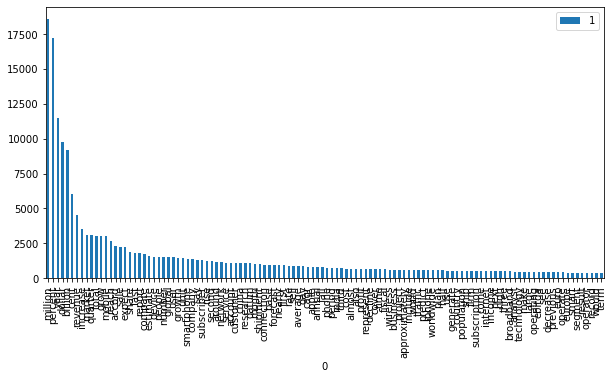

In [45]:
# визуализация наиболее часто встречающихся слов
value_count=400
df1[df1[1]>value_count].plot.bar(x=0,y=1,figsize=(10,5))

4804


<AxesSubplot:xlabel='0'>

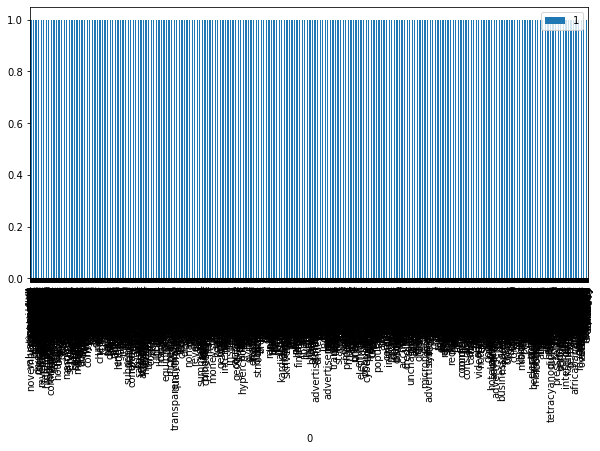

In [46]:
# визуализация наиболее редко встречающихся слов
print(df1[df1[1]<2].shape[0])
df1[df1[1]<2].plot.bar(x=0,y=1,figsize=(10,5))

In [47]:
# генерация мешка слов.
#max_features=1500, сколько термов берем в расчет
#min_df=5, если слово встречается меньшее число раз то игнорируем
#max_df=0.7 верхний порог. если терм встречается в большей доле документов то игнорируем
count_vect = CountVectorizer(max_features=1500, min_df=5, max_df=0.6)
bow = count_vect.fit_transform(df['Clean_sentence'].values)
bow.shape

(28942, 1500)

In [48]:
bow

<28942x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 247663 stored elements in Compressed Sparse Row format>

In [49]:
#print(bow)

In [50]:
# посмотреть какие слова попали в мешок слов
terms = count_vect.get_feature_names()

c:\users\ysiberia\documents\github\market-growth-claims\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [51]:
#first 10 columns generated by BOW
terms[1440:]

['virtual',
 'visitors',
 'visits',
 'vivo',
 'vodafone',
 'voice',
 'voip',
 'volte',
 'volume',
 'volumes',
 'votes',
 'wall',
 'waste',
 'watch',
 'water',
 'wearable',
 'wearables',
 'website',
 'wednesday',
 'week',
 'weeks',
 'well',
 'went',
 'western',
 'whatsapp',
 'whereas',
 'whole',
 'whopping',
 'wide',
 'wifi',
 'wimax',
 'windows',
 'wire',
 'wired',
 'wireless',
 'wireline',
 'within',
 'without',
 'witnessed',
 'wlan',
 'women',
 'work',
 'workers',
 'workforce',
 'working',
 'world',
 'worldwide',
 'worth',
 'would',
 'write',
 'xiaomi',
 'year',
 'yearly',
 'years',
 'yet',
 'york',
 'youtube',
 'yuan',
 'zero',
 'zigbee']

In [52]:
bow

<28942x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 247663 stored elements in Compressed Sparse Row format>

## BERT

In [53]:

from sentence_transformers import SentenceTransformer

In [55]:
# я выбрал семантическое ядро all-MiniLM-L6-v2. По сути на ХаггингФэйс у всех 
#семантических ядер близкие параметры. Это работает быстрее
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [56]:
X = df["Clean_sentence_lemm_spacy"].values.tolist()
corpus_embeddings = embedder.encode(X, show_progress_bar=True, batch_size=1)

Batches:   0%|          | 0/28942 [00:00<?, ?it/s]

In [57]:
corpus_embeddings

array([[ 0.05959082, -0.02219997,  0.02948871, ..., -0.05612655,
         0.08812767,  0.01353668],
       [ 0.0821851 , -0.05739311, -0.04545336, ..., -0.01988084,
        -0.02690098,  0.08722438],
       [ 0.02837871, -0.05293957, -0.0289657 , ...,  0.01958729,
        -0.02877357, -0.00046728],
       ...,
       [-0.02460481,  0.06306286, -0.03477943, ..., -0.07036576,
        -0.06622985, -0.04928489],
       [ 0.01940229, -0.03306864,  0.00711769, ..., -0.05866372,
         0.01911801, -0.02725434],
       [-0.0216095 ,  0.01859156, -0.05022538, ..., -0.06426142,
        -0.00793428,  0.01774814]], dtype=float32)

## Word2Vec  
Векторизация текстов на основе w2v от gensim.

In [58]:
X = df["Clean_sentence_lemm_spacy"].values.tolist()

In [59]:
# 
w2v_model=gensim.models.Word2Vec(X,vector_size=200, 
                                 workers=4,
                                 window=5,# окно контекста
                                   min_count=2)

In [60]:
import numpy as np
sent_vectors = []; # the
for sent in X: # 
    sent_vec = np.zeros(200) # 
    cnt_words =0; # 
    for word in sent: # 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors = np.array(sent_vectors)
sent_vectors = np.nan_to_num(sent_vectors)
sent_vectors.shape

C:\Users\Ysiberia\AppData\Local\Temp\ipykernel_13020\2526275276.py:13: RuntimeWarning: invalid value encountered in true_divide
  sent_vec /= cnt_words


(28942, 200)

In [61]:
sent_vectors[1]

array([-0.02302716,  0.02553372,  0.01084309, -0.11483511, -0.00992141,
       -0.03717412, -0.04884831,  0.06947688,  0.01437749, -0.01688569,
        0.09199112, -0.05796753,  0.01188803, -0.10335119, -0.01816833,
        0.0335619 , -0.00065544, -0.08930936, -0.02702576, -0.03091276,
       -0.07956206,  0.01442322, -0.02815197, -0.0586245 , -0.18245009,
       -0.00861882,  0.08856691, -0.08505704,  0.03483082,  0.06639856,
       -0.13150444, -0.02641678, -0.06333927,  0.07874959,  0.07819493,
        0.06244955, -0.03752541, -0.05196842,  0.00533529,  0.09551743,
        0.03187826, -0.01211947, -0.03238153,  0.05542121, -0.00070848,
       -0.03389306,  0.12084296,  0.03285613, -0.06300577, -0.05393413,
        0.0144838 ,  0.06511074,  0.0878283 ,  0.03898694, -0.03650292,
        0.01358534,  0.0140377 ,  0.04904432,  0.10151473, -0.0248318 ,
       -0.03031829, -0.07504188,  0.02184197,  0.01442705, -0.00630427,
       -0.0003414 , -0.01094604, -0.02036682, -0.05253674, -0.01

# Clustering

Кластеризация. Проводится 3 методами (KMeans, DBSCAN, AgglomerativeClustering), для каждого представления эмбедингов(word2vec,tfidf,bert,bag_of_words).  
ТАм где возможно проводится анализ параметров. НО не полным перебором

In [62]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

In [63]:
import gc

In [64]:
#Далее кластеризация представлена будет примерно по одной схеме:
#Кластеризуем и добавляем лейблы новым столбцом в датасет.  
#Имя столбца - *метод построение эмбедингов*_*алгоритм кластеризации*_*параметры алгоритма*


100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:32<00:00,  4.08s/it]


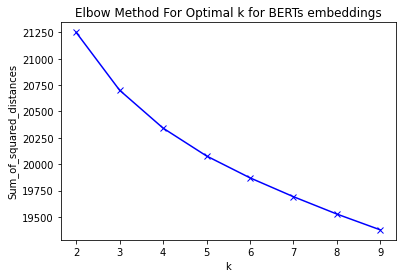

In [65]:
#Для наглядности строится зависимость суммы квадратов расстояний м\у элементом и 
#центром его кластера от количества кластеров.
#Расстояния зависят и от метода построения эмбедингов(разные масштабы)
Sum_of_squared_distances = []
K = range(2,10)
for k in tqdm.tqdm(K):
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(corpus_embeddings)
    Sum_of_squared_distances.append(km.inertia_)
    column_name=f'Bert_embed_K_means_{k}_clusters'
    labels = km.labels_
    df[column_name]=labels.tolist()
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k for BERTs embeddings')
plt.show()

In [66]:
df.to_excel(out_path)

In [67]:
gc.collect()

405375

100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:17<00:00,  2.15s/it]


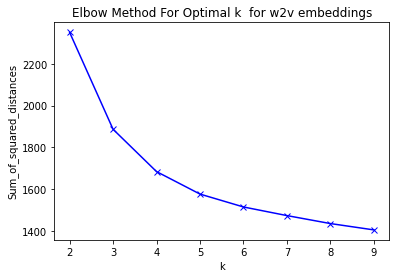

In [68]:
Sum_of_squared_distances = []
K = range(2,10)
for k in tqdm.tqdm(K):
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(sent_vectors)
    Sum_of_squared_distances.append(km.inertia_)
    column_name=f'w2v_embed_K_means_{k}_clusters'
    labels = km.labels_
    df[column_name]=labels.tolist()
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k  for w2v embeddings')
plt.show()

In [69]:
df.to_excel(out_path)

In [70]:
gc.collect()

636927

100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [04:47<00:00, 35.98s/it]


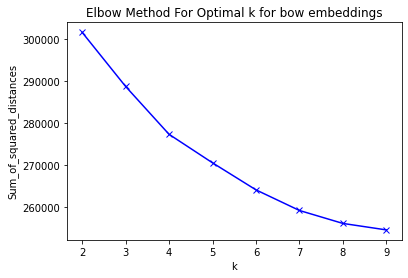

In [71]:
Sum_of_squared_distances = []
K = range(2,10)
for k in tqdm.tqdm(K):
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(bow)
    Sum_of_squared_distances.append(km.inertia_)
    column_name=f'bow_embed_K_means_{k}_clusters'
    labels = km.labels_
    df[column_name]=labels.tolist()
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k for bow embeddings')
plt.show()


In [72]:
df.to_excel(out_path)

In [73]:
gc.collect()

868479

100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [06:55<00:00, 51.91s/it]


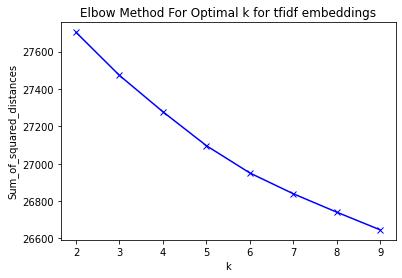

In [74]:
Sum_of_squared_distances = []
K = range(2,10)
for k in tqdm.tqdm(K):
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X_train_tfidf)
    Sum_of_squared_distances.append(km.inertia_)
    column_name=f'tfidf_embed_K_means_{k}_clusters'
    labels = km.labels_
    df[column_name]=labels.tolist()
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k for tfidf embeddings')
plt.show()

In [75]:
df.to_excel(out_path)

In [76]:
gc.collect()

1100031

In [77]:
n_clusters=5

In [78]:
# небольшой пример получения популярных слов в кластерих. монограмы
km = KMeans(n_clusters=n_clusters, max_iter=200, n_init=10)
km = km.fit(corpus_embeddings) #word to vec
Sum_of_squared_distances.append(km.inertia_)

In [79]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(n_clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms1[ind], end='')
        print()

Top terms per cluster:
Cluster 0: aimonetti
 accel
 abrha
 affo
 accelerated
 admin
 allege
 ahonen
 acreage
 abridge
Cluster 1: abrha
 adjacent
 allege
 africa
 ahead
 acreage
 achieve
 aimonetti
 afford
 accel
Cluster 2: abrha
 adjacent
 aeroblade
 aforementione
 adjustment
 allege
 accel
 africa
 afternoon
 alfa
Cluster 3: abrha
 accel
 aged
 aimonetti
 aforementione
 airfare
 aids
 abandon
 advertisementgrowing
 airtouch
Cluster 4: abrha
 afternoon
 allege
 aeroblade
 africa
 accelerated
 adjacent
 abridge
 accel
 aldebaran


## DBScan

In [80]:
#Считаю расстояние между minPts близжайшими соседями.
#
minPts = 100 # количество ближайших соседей до которых считаем расстояние
def lower_bound(nums, target): 
    l, r = 0, len(nums) - 1
    while l <= r: # Binary searching.
        mid = int(l + (r - l) / 2)
        if nums[mid] >= target:
            r = mid - 1
        else:
            l = mid + 1
    return l

def compute200thnearestneighbour(x, data): 
    dists = []
    for val in data:
        dist = np.sum((x - val) **2 ) 
        if(len(dists) == minPts and dists[minPts-1] > dist): 
            l = int(lower_bound(dists, dist)) 
            if l < minPts and l >= 0 and dists[l] > dist:
                dists[l] = dist
        else:
            dists.append(dist)
            dists.sort()
    
    return dists[minPts-1] 

In [89]:
# besprovodnaya_svyaz__0_95_classification rows=int(sent_vectors.shape[0]*0.1)
rows=int(sent_vectors.shape[0]*0.2)
rows

2894

In [90]:
#для каждого объекта считается расстояние от него до 200 близжйших
#потенциально не обязательно 200.
#делается для оптимального выбора параметра eps в DBSCAN. 
#Значение надо брать в меньше чем y где график начинает резко расти
#
twohundrethneigh = []
for val in sent_vectors[:rows]:
    twohundrethneigh.append( compute200thnearestneighbour(val, sent_vectors[:rows]) ) # rows можно заменитиь на число поменьше
twohundrethneigh.sort()

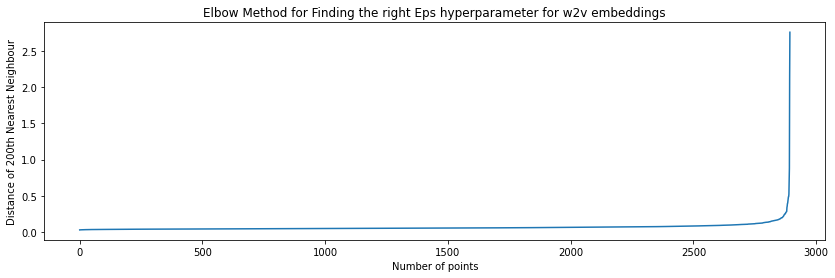

In [91]:
# зависимость расстояния до 200 близжйших соседей от количества учитываемых точек
plt.figure(figsize=(14,4))
plt.title("Elbow Method for Finding the right Eps hyperparameter for w2v embeddings")
plt.plot([x for x in range(len(twohundrethneigh))], twohundrethneigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of 200th Nearest Neighbour")
plt.show()

In [92]:
gc.collect()

3171

In [95]:
# кластеризация и сразу добавление лейблов датафрейм
#besprovodnaya_svyaz__0_95_classification DBSCAN(eps = 0.25, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.25, min_samples = minPts, metric='cosine', n_jobs=-1)
model.fit(sent_vectors)
labels = model.labels_
print(set(labels))


{0, -1}


In [96]:
column_name=f'w2v_embed_DBSCAN_0.25_eps'
df[column_name]=labels.tolist()

In [97]:
gc.collect()

144

In [99]:
#besprovodnaya_svyaz__0_95_classification DBSCAN(eps = 0.05, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.05, min_samples = 100, metric='cosine', n_jobs=-1)
model.fit(sent_vectors)
labels = model.labels_
print(set(labels)) # список классов


{0, -1}


In [100]:
column_name=f'w2v_embed_DBSCAN_0.05_eps'
df[column_name]=labels.tolist()

In [101]:
df.to_excel(out_path)

In [102]:
bow_ar= bow.toarray() # из разреженной матрицы в обычный массив для работы алгоритма

In [103]:
twohundrethneigh = []
for val in bow_ar[:rows]:
    twohundrethneigh.append( compute200thnearestneighbour(val, bow_ar[:rows]) )
twohundrethneigh.sort()

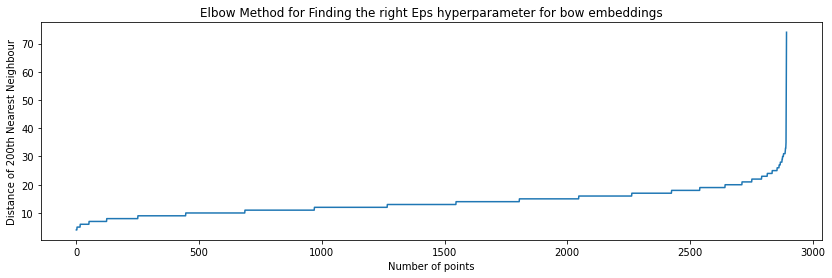

In [104]:
plt.figure(figsize=(14,4))
plt.title("Elbow Method for Finding the right Eps hyperparameter for bow embeddings")
plt.plot([x for x in range(len(twohundrethneigh))], twohundrethneigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of 200th Nearest Neighbour")
plt.show()

In [105]:
gc.collect()

1161013

In [112]:
#besprovodnaya_svyaz__0_95_classification DBSCAN(eps = 0.9, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.9, min_samples = 100, metric='cosine', n_jobs=-1)
model.fit(bow_ar)
labels = model.labels_
print(set(labels))


{0, -1}


In [113]:
column_name=f'bow_embed_DBSCAN_0.9_eps'
df[column_name]=labels.tolist()

In [115]:
#besprovodnaya_svyaz__0_95_classification DBSCAN(eps = 0.5, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.5, min_samples = 100, metric='cosine', n_jobs=-1)
model.fit(bow_ar)
labels = model.labels_
print(set(labels))


{0, -1}


In [116]:
column_name=f'bow_embed_DBSCAN_0.5_eps'
df[column_name]=labels.tolist()

In [117]:
gc.collect()

312

In [118]:
#besprovodnaya_svyaz__0_95_classification DBSCAN(eps = 0.35, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.35, min_samples = 100, metric='cosine', n_jobs=-1)
model.fit(bow_ar)
labels = model.labels_
print(set(labels))


{0, 1, -1}


In [119]:
column_name=f'bow_embed_DBSCAN_0.35_eps'
df[column_name]=labels.tolist()

In [120]:
gc.collect()

48

In [121]:
df.to_excel(out_path)

In [122]:
# Computing the 200th nearest neighbour distance of some point the dataset:
twohundrethneigh = []
for val in corpus_embeddings[:rows]:
    twohundrethneigh.append( compute200thnearestneighbour(val, corpus_embeddings[:rows]) )
twohundrethneigh.sort()

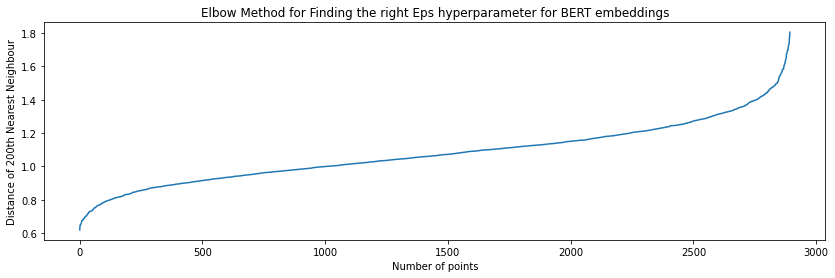

In [123]:
# Plotting for the Elbow Method :
plt.figure(figsize=(14,4))
plt.title("Elbow Method for Finding the right Eps hyperparameter for BERT embeddings")
plt.plot([x for x in range(len(twohundrethneigh))], twohundrethneigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of 200th Nearest Neighbour")
plt.show()

In [125]:
#besprovodnaya_svyaz__0_95_classification DBSCAN(eps = 0.35, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.25, min_samples = 100, metric='cosine', n_jobs=-1)
model.fit(corpus_embeddings)
labels = model.labels_
print(set(labels))


{0, 1, -1}


In [126]:
column_name=f'BERT_embed_DBSCAN_0.25_eps'
df[column_name]=labels.tolist()

In [127]:
df.to_excel(out_path)

In [128]:
gc.collect()

1273695

In [129]:
#besprovodnaya_svyaz__0_95_classification DBSCAN(eps = 0.35, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.20, min_samples = 100, metric='cosine', n_jobs=-1)
model.fit(corpus_embeddings)
labels = model.labels_
print(set(labels))


{0, 1, -1}


In [130]:
column_name=f'BERT_embed_DBSCAN_0.2_eps'
df[column_name]=labels.tolist()

In [131]:
df.to_excel(out_path)

In [132]:
gc.collect()

1302639

In [133]:
# для крупных файлов 
X_train_tfidf_arr=X_train_tfidf.toarray()
X_train_tfidf_arr.shape

(28942, 11633)

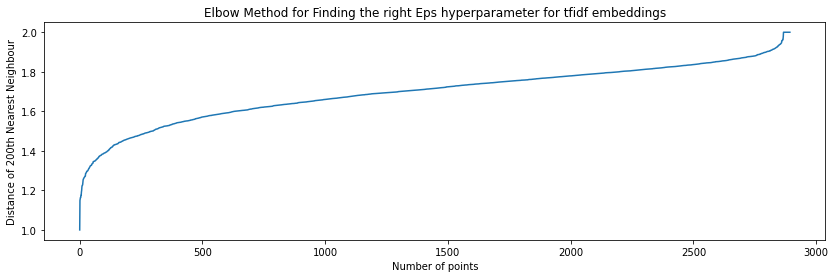

In [134]:

twohundrethneigh = []
for val in X_train_tfidf_arr[:rows]:
    twohundrethneigh.append( compute200thnearestneighbour(val, X_train_tfidf_arr[:rows]) )
twohundrethneigh.sort()
# Plotting for the Elbow Method :
plt.figure(figsize=(14,4))
plt.title("Elbow Method for Finding the right Eps hyperparameter for tfidf embeddings")
plt.plot([x for x in range(len(twohundrethneigh))], twohundrethneigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of 200th Nearest Neighbour")
plt.show()

In [140]:
#besprovodnaya_svyaz__0_95_classification DBSCAN(eps = 0.7, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.7, min_samples = minPts, metric='cosine', n_jobs=-1)
model.fit(X_train_tfidf_arr)
labels = model.labels_
print(set(labels))


{0, -1}


In [141]:
column_name=f'tfidf_embed_DBSCAN_0.7_eps'
df[column_name]=labels.tolist()

In [142]:
gc.collect()

1313

In [143]:
df.to_excel(out_path)

In [144]:
#besprovodnaya_svyaz__0_95_classification DBSCAN(eps = 0.6, min_samples = 100, metric='cosine', n_jobs=-1)
model = DBSCAN(eps = 0.6, min_samples = minPts, metric='cosine', n_jobs=-1)
model.fit(X_train_tfidf_arr)
labels = model.labels_
print(set(labels))


{0, -1}


In [145]:
column_name=f'tfidf_embed_DBSCAN_0.6_eps'
df[column_name]=labels.tolist()

In [146]:
df.to_excel(out_path)

In [147]:
gc.collect()

1360527

## Clustering Hierarchical
работает очень долго!

In [148]:
K = range(2,5)
for k in tqdm.tqdm(K):
    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  #took n=5 from dendrogram curve 
    Agg=cluster.fit_predict(sent_vectors)
    column_name=f'w2v_embed_Agg_{k}_clusters'
    labels = km.labels_
    df[column_name]=labels.tolist()


100%|██████████████████████████████████████████████████████████████████████████████| 3/3 [07:27<00:00, 149.20s/it]


In [149]:
df.to_excel(out_path)

In [150]:
gc.collect()

1447359

In [151]:
K = range(2,5)
for k in tqdm.tqdm(K):
    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  #took n=5 from dendrogram curve 
    Agg=cluster.fit_predict(bow_ar)
    column_name=f'bow_embed_Agg_{k}_clusters'
    labels = km.labels_
    df[column_name]=labels.tolist()

100%|██████████████████████████████████████████████████████████████████████████████| 3/3 [22:01<00:00, 440.40s/it]


In [152]:
df.to_excel(out_path)

In [153]:
gc.collect()

1534191

In [154]:
K = range(2,5)
for k in tqdm.tqdm(K):
    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  #took n=5 from dendrogram curve 
    Agg=cluster.fit_predict(corpus_embeddings)
    column_name=f'bert_embed_Agg_{k}_clusters'
    labels = km.labels_
    df[column_name]=labels.tolist()

100%|██████████████████████████████████████████████████████████████████████████████| 3/3 [09:40<00:00, 193.54s/it]


In [155]:
df.to_excel(out_path)

In [ ]:
K = range(2,5)
for k in tqdm.tqdm(K):
    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  #took n=5 from dendrogram curve 
    Agg=cluster.fit_predict(X_train_tfidf_arr)
    column_name=f'tfidf_embed_Agg_{k}_clusters'
    labels = km.labels_
    df[column_name]=labels.tolist()

  0%|                                                                                       | 0/3 [00:00<?, ?it/s]

In [ ]:
df.to_excel(out_path)

## Searching best result

In [5]:
df=pd.read_excel('data/besprovodnaya_svyaz__0_95_classification_output.xlsx')

In [7]:
#оставляем только нужные колонки 'Clean_sentence_lemm_nltk',
df=df.drop(columns=['Clean_sentence_lemm_spacy', 'Bert_embed_K_means_2_clusters',
       'Bert_embed_K_means_4_clusters',
       'Bert_embed_K_means_5_clusters', 'Bert_embed_K_means_6_clusters',
       'Bert_embed_K_means_7_clusters', 'Bert_embed_K_means_8_clusters',
       'Bert_embed_K_means_9_clusters', 'w2v_embed_K_means_2_clusters',
       'w2v_embed_K_means_3_clusters', 'w2v_embed_K_means_4_clusters',
       'w2v_embed_K_means_5_clusters', 'w2v_embed_K_means_6_clusters',
       'w2v_embed_K_means_7_clusters', 'w2v_embed_K_means_8_clusters',
       'w2v_embed_K_means_9_clusters', 'bow_embed_K_means_2_clusters',
       'bow_embed_K_means_3_clusters', 'bow_embed_K_means_4_clusters',
       'bow_embed_K_means_5_clusters', 'bow_embed_K_means_6_clusters',
       'bow_embed_K_means_7_clusters', 'bow_embed_K_means_8_clusters',
       'bow_embed_K_means_9_clusters', 'tfidf_embed_K_means_2_clusters',
       'tfidf_embed_K_means_3_clusters', 'tfidf_embed_K_means_4_clusters',
       'tfidf_embed_K_means_5_clusters', 'tfidf_embed_K_means_6_clusters',
       'tfidf_embed_K_means_7_clusters', 'tfidf_embed_K_means_8_clusters',
       'tfidf_embed_K_means_9_clusters', 'w2v_embed_DBSCAN_0.25_eps',
       'w2v_embed_DBSCAN_0.05_eps', 'bow_embed_DBSCAN_0.9_eps',
       'bow_embed_DBSCAN_0.5_eps', 'bow_embed_DBSCAN_0.35_eps',
       'BERT_embed_DBSCAN_0.25_eps',
       'tfidf_embed_DBSCAN_0.7_eps', 'tfidf_embed_DBSCAN_0.6_eps',
       'w2v_embed_Agg_2_clusters', 'w2v_embed_Agg_3_clusters',
       'w2v_embed_Agg_4_clusters', 'bow_embed_Agg_2_clusters',
       'bow_embed_Agg_3_clusters', 'bow_embed_Agg_4_clusters',
       'bert_embed_Agg_2_clusters', 'bert_embed_Agg_3_clusters',
       'bert_embed_Agg_4_clusters'],axis=1)        
df=df.dropna(axis='index')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28935 entries, 0 to 28941
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Unnamed: 0                     28935 non-null  int64 
 1   sentence                       28935 non-null  object
 2   Clean_sentence                 28935 non-null  object
 3   Clean_sentence_lemm_nltk       28935 non-null  object
 4   Bert_embed_K_means_3_clusters  28935 non-null  int64 
 5   BERT_embed_DBSCAN_0.2_eps      28935 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.5+ MB


## Search n-grams

In [8]:
def search_ngrams(data:list, n_size:int):
    n_grams_counter={}
    for sentence in data:
        sentence=sentence.split(' ')
        for word in range(len(sentence)-n_size+1):
            n_gramma=sentence[word:word+n_size]
            n_gramma=' '.join([w for w in n_gramma])
            if n_gramma in n_grams_counter.keys():
                n_grams_counter[n_gramma]+=1
            else:
                n_grams_counter[n_gramma]=1
    return n_grams_counter

In [13]:
X_Kmean_0 = df.Clean_sentence_lemm_nltk[df.Bert_embed_K_means_3_clusters==0].values.tolist()
X_Kmean_1 = df.Clean_sentence_lemm_nltk[df.Bert_embed_K_means_3_clusters==1].values.tolist()
X_Kmean_2 = df.Clean_sentence_lemm_nltk[df.Bert_embed_K_means_3_clusters==2].values.tolist()

In [14]:
bigrams_X_Kmean_0=search_ngrams(X_Kmean_0,2)
bigrams_X_Kmean_1=search_ngrams(X_Kmean_1,2)
bigrams_X_Kmean_2=search_ngrams(X_Kmean_2,2)

In [15]:
tergrams_X_Kmean_0=search_ngrams(X_Kmean_0,3)
tergrams_X_Kmean_1=search_ngrams(X_Kmean_1,3)
tergrams_X_Kmean_2=search_ngrams(X_Kmean_2,3)

In [16]:
fourgrams_X_Kmean_0=search_ngrams(X_Kmean_0,4)
fourgrams_X_Kmean_1=search_ngrams(X_Kmean_1,4)
fourgrams_X_Kmean_2=search_ngrams(X_Kmean_2,4)

In [17]:
fivegrams_X_Kmean_0=search_ngrams(X_Kmean_0,5)
fivegrams_X_Kmean_1=search_ngrams(X_Kmean_1,5)
fivegrams_X_Kmean_2=search_ngrams(X_Kmean_2,5)

{'looking autonomous': 2,
 'autonomous vehicle': 9,
 'vehicle example': 2,
 'example latency': 2,
 'latency millisecond': 2,
 'millisecond mean': 2,
 'mean data': 2,
 'data shared': 3,
 'shared car': 2,
 'car travelling': 2,
 'travelling mile': 2,
 'mile hour': 35,
 'hour millimeter': 2,
 'fund invests': 1,
 'invests percent': 2,
 'percent portfolio': 10,
 'portfolio intel': 1,
 'intel percent': 4,
 'percent nvidia': 4,
 'nvidia percent': 2,
 'percent amd': 1,
 'stock average': 5,
 'average target': 2,
 'target price': 2,
 'price dollar': 9,
 'dollar potential': 1,
 'potential downside': 1,
 'downside around': 1,
 'around percent': 114,
 'percent next': 11,
 'next month': 7,
 'third quarter': 59,
 'quarter discrete': 1,
 'discrete gpu': 1,
 'gpu market': 1,
 'market share': 297,
 'share rose': 15,
 'rose percent': 107,
 'percent percent': 749,
 'percent previous': 20,
 'previous quarter': 19,
 'quarter according': 11,
 'peaked percent': 1,
 'percent second': 25,
 'second quarter': 74,
